In [16]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models
#import models.simple_depth_morph_models as simple_models
# import models.shallow_depth_morph_models_org as sdmodels

import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

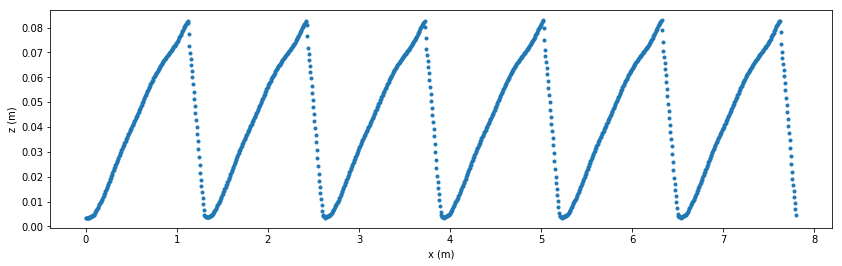

In [17]:
filepath = '../Paper_3/dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## Non-equilibrium (20 cm)

In [51]:
import pandas as pd
section52ResultsDf = pd.read_csv('Section_5.3_20cm_results.csv', index_col=0)
section52ResultsDf.head()

obsheightdf = pd.read_csv('a3down_dune_height.txt',sep='\t')
obslengthdf = pd.read_csv('a3down_dune_length.txt',sep='\t')
obsmigratedf = pd.read_csv('a3down_dune_migration.txt',sep='\t')

(80, 170)

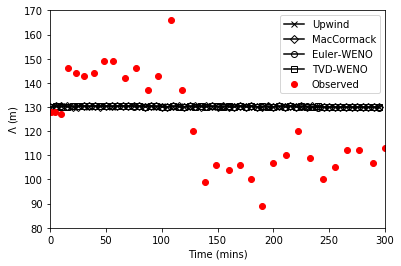

In [52]:
marker_size = 6
axis_font_size = 10
label_font_size = 10
#plt.style.use(['default'])
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_length*100, 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_length*100, 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_length*100, 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_length*100, 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)

plt.plot(obslengthdf['t'],obslengthdf['dune'], 'o',color='r', label='Observed')



ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)

plt.ylabel('$\Lambda$ (m)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
    
plt.legend(fontsize=label_font_size)
#plt.tick_params(axis='both', which='major', labelsize=label_font_size)
#plt.tight_layout()

plt.xlim([0,300])
plt.ylim([80, 170])

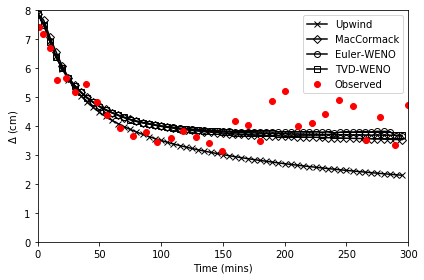

In [53]:
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_height, 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_height, 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_height, 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_height, 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)

plt.plot(obsheightdf['t'],obsheightdf['dune'], 'o',color='r', label='Observed')

ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)


    
plt.ylabel('$\Delta$ (cm)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
plt.ylim([0,8])
plt.legend(fontsize=label_font_size)
plt.tick_params(axis='both', which='major', labelsize=label_font_size)
plt.tight_layout()

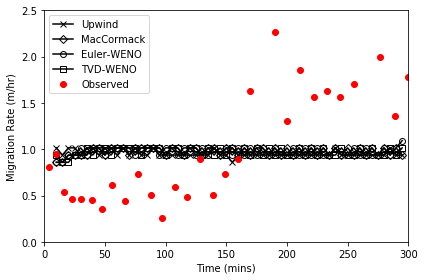

In [54]:
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_wavespeed, 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_wavespeed, 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_wavespeed, 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_wavespeed, 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)



ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)
    
plt.plot(obsmigratedf['t'],obsmigratedf['dune'], 'o',color='r', label='Observed')

plt.ylabel('Migration Rate (m/hr)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
plt.ylim([0.0,2.5])
plt.legend(fontsize=label_font_size)
plt.tick_params(axis='both', which='major', labelsize=label_font_size)
plt.tight_layout()

### TVD-WENO

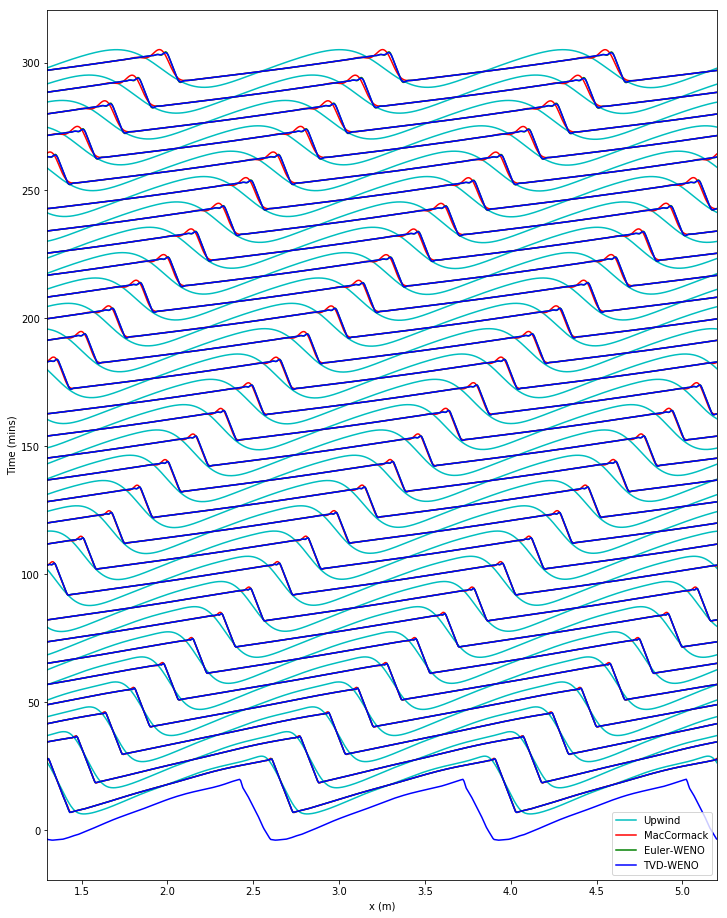

In [25]:
vertsArray = {}
run_name = 'Section_5.3.dune_5_upwind_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Upwind'] = verts

run_name = 'Section_5.3.dune_5_MacCormack_q_20m_h_237mm_D50_1.0mm_smoothed_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['MacCormack'] = verts

run_name = 'Section_5.3.dune_5_EulerWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Euler-WENO'] = verts

run_name = 'Section_5.3.dune_5_TVDWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['TVD-WENO'] = verts

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

colors=['c','r','g','b','m']
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0, 300*z0 - 5., color='b')
j=0
nameslist=[]
arrlist =[]
firstplot = True
for verts in vertsArray.items():
    i=0
    insert = False
    name = verts[0]
    verts = verts[1]
    for t in verts[:,0,0]:
        if insert == True:
            if firstplot == True:
                plt.plot(verts[i,:,0], (300*verts[i,:,1] + i*dt),color=colors[j],label=name)
                firstplot=False
            else:
                plt.plot(verts[i,:,0], (300*verts[i,:,1] + i*dt),color=colors[j])
            insert = False
        else:
            #plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color=colors[j],label=verts[0])
            insert = True
        i+=1
    j+=1
    firstplot=True
    
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')
ax.set_xlim([1.3,4*1.3])
plt.legend()

Text(0.5, 0, 'x (m)')

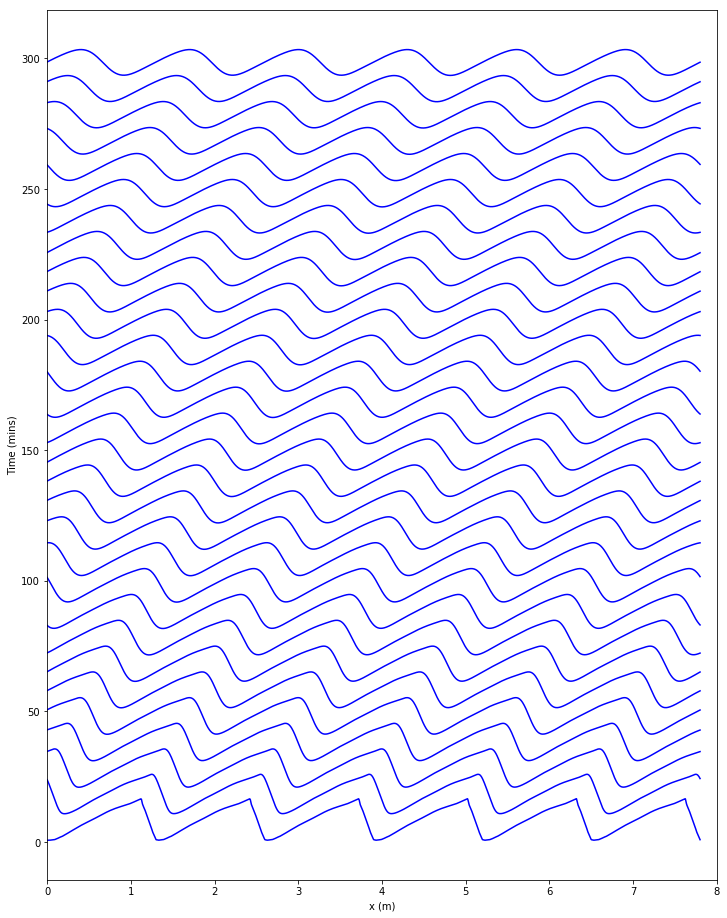

In [26]:
run_name = 'Section_5.3.dune_5_upwind_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

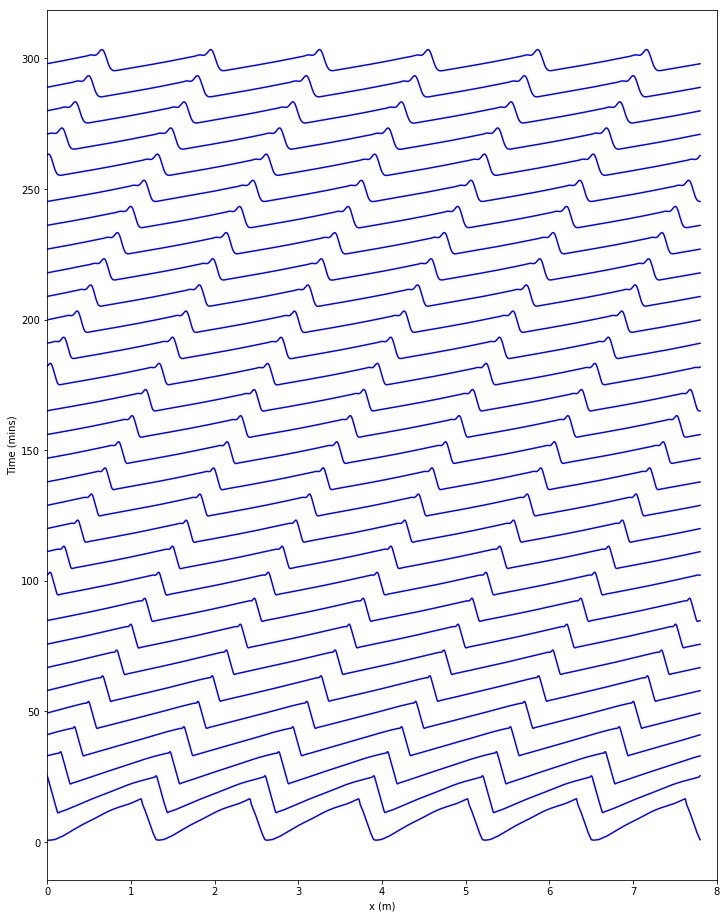

In [27]:
run_name = 'Section_5.3.dune_5_MacCormack_q_20m_h_237mm_D50_1.0mm_smoothed_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

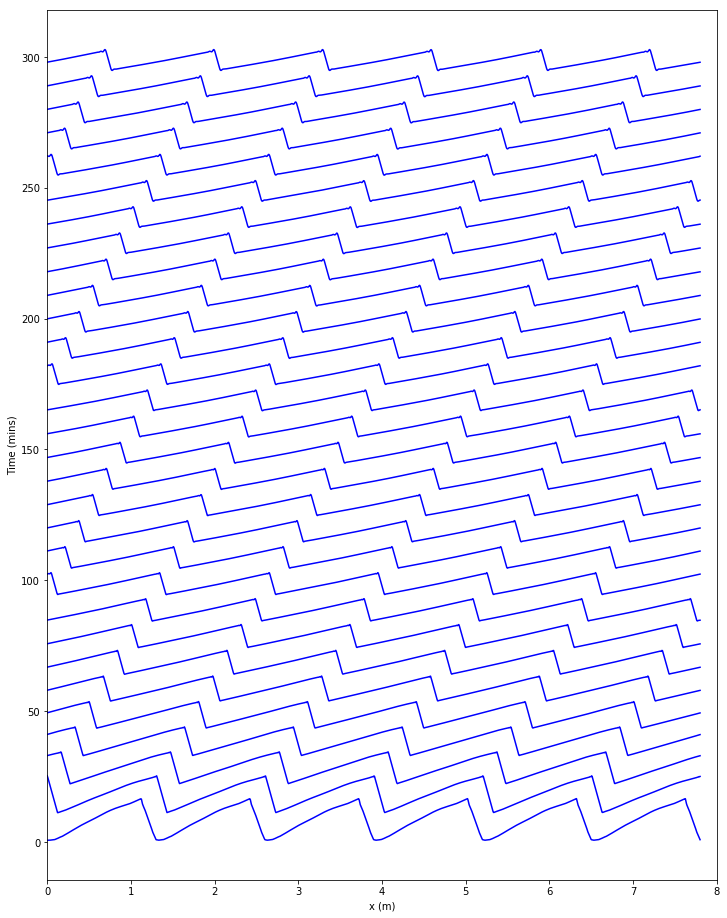

In [28]:
run_name = 'Section_5.3.dune_5_EulerWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

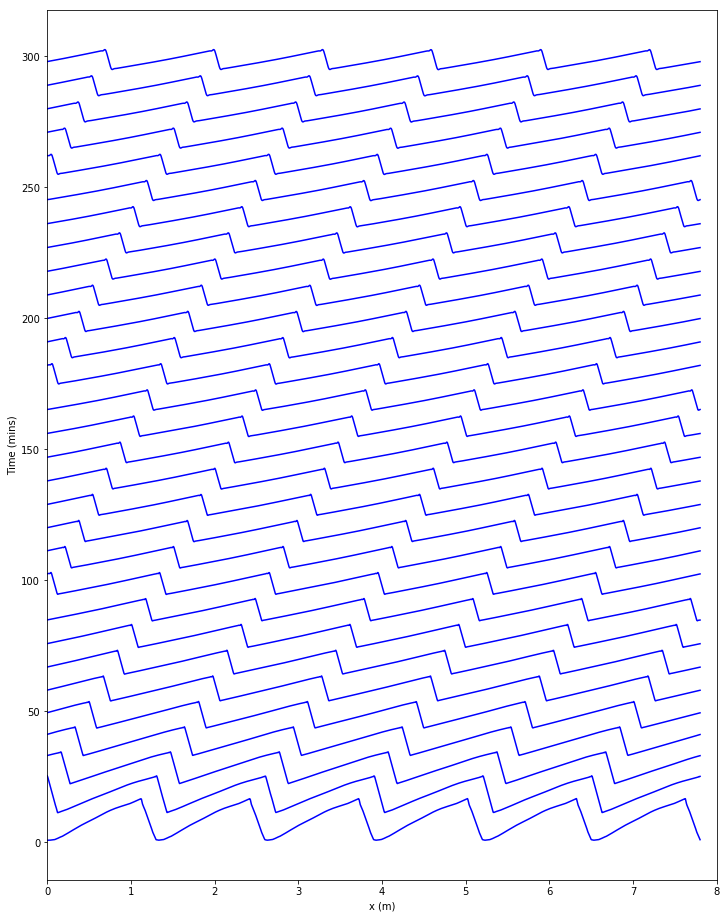

In [11]:
run_name = 'Section_5.3.dune_5_TVDWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

# 32 cm - Equlibrium Flows

In [47]:
section52ResultsDf = pd.read_csv('Section_5.3_32cm_results.csv', index_col=0)
section52ResultsDf.head()

,Upwind_length,MacCormack_length,EulerWENO_length,TVDWENO_length,Upwind_height,MacCormack_height,EulerWENO_height,TVDWENO_height,Upwind_wavespeed,MacCormack_wavespeed,EulerWENO_wavespeed,TVDWENO_wavespeed
﻿Time,,,,,,,,,,,,
0,1.300000,1.300000,1.300000,1.300000,7.890000,7.890000,7.890000,7.890000,NaN,NaN,NaN,NaN
5,1.303253,1.303253,1.301084,1.303253,7.691493,7.913059,7.922325,7.907034,NaN,NaN,NaN,NaN
10,1.303253,1.303253,1.297832,1.303253,7.579918,7.902393,7.927109,7.899872,1.092911,1.014846,0.936781,1.014846
15,1.301084,1.303253,1.297832,1.303253,7.496653,7.897301,7.931973,7.895339,1.092911,1.014846,1.014846,1.014846
20,1.301084,1.303253,1.297832,1.303253,7.428579,7.893697,7.936321,7.891628,1.014846,1.014846,0.936781,1.014846


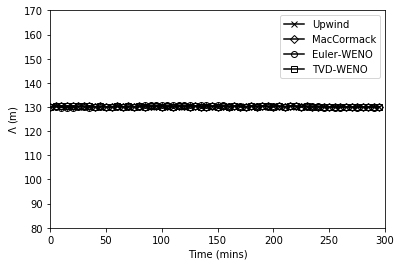

In [48]:
#plt.style.use(['default'])
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_length*100., 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_length*100., 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_length*100., 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_length*100., 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)

plt.ylabel('Lenght (m)')
plt.xlabel('Time (s)')


ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)

plt.ylabel('$\Lambda$ (m)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
plt.ylim([80, 170])
    
plt.legend(fontsize=label_font_size)
#plt.tick_params(axis='both', which='major', labelsize=label_font_size)
#plt.tight_layout()


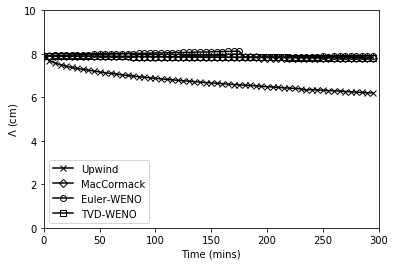

In [49]:
#plt.style.use(['default'])
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_height, 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_height, 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_height, 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_height, 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)

plt.ylabel('Lenght (m)')
plt.xlabel('Time (s)')


ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)

plt.ylabel('$\Lambda$ (cm)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
plt.ylim([0,10])
plt.legend(fontsize=label_font_size)

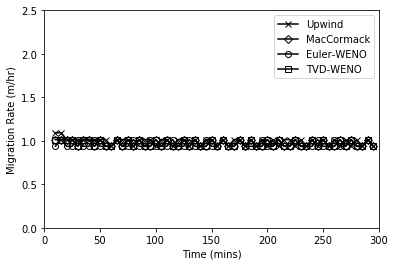

In [50]:
#plt.style.use(['default'])
plt.plot(section52ResultsDf.index, section52ResultsDf.Upwind_wavespeed, 
         'x-', color='k', label='Upwind', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.MacCormack_wavespeed, 
         'D-', fillstyle='none', color='k', label='MacCormack', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.EulerWENO_wavespeed, 
         'o-', fillstyle='none', color='k', label='Euler-WENO', markersize=marker_size)
plt.plot(section52ResultsDf.index, section52ResultsDf.TVDWENO_wavespeed, 
         's-', fillstyle='none', color='k', label='TVD-WENO', markersize=marker_size)

plt.ylabel('Lenght (m)')
plt.xlabel('Time (s)')


ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(axis_font_size)

plt.ylabel('Migration Rate (m/hr)', fontsize=label_font_size)
plt.xlabel('Time (mins)', fontsize=label_font_size)
plt.xlim([0,300])
plt.ylim([0.0,2.5])
plt.legend(fontsize=label_font_size)

Text(0.5, 0, 'x (m)')

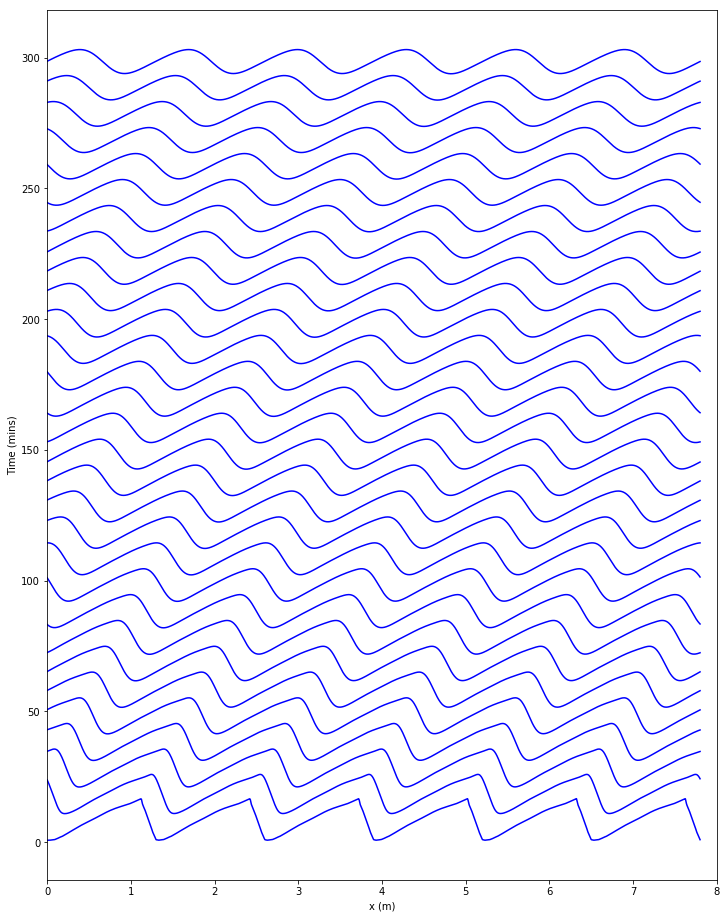

In [46]:
run_name = 'Section_5.3.dune_5_upwind_q_32m_h_357mm_D50_1.0mm_2ndTVD_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

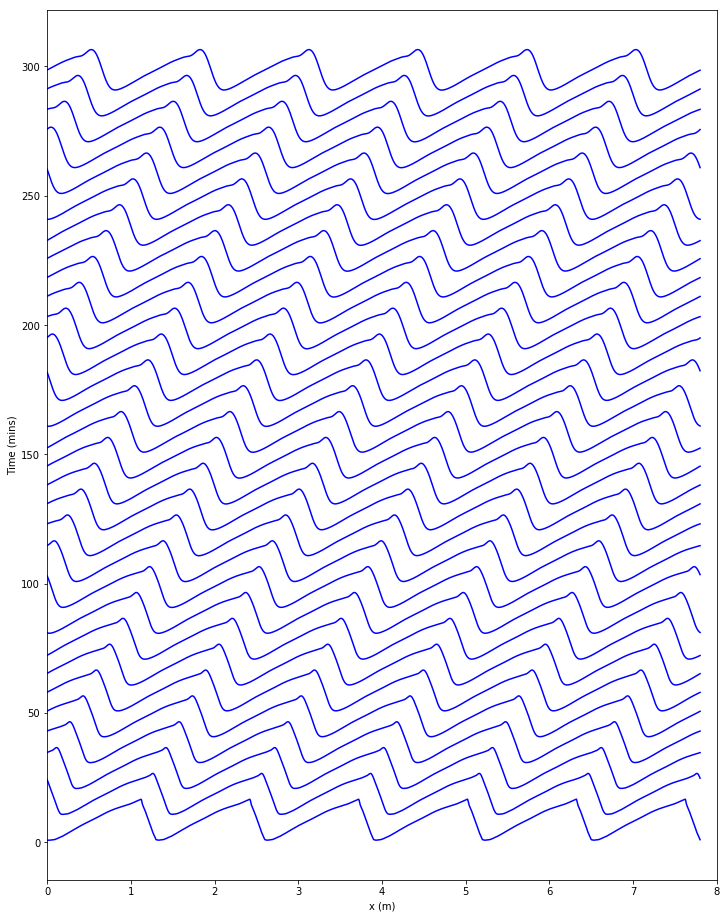

In [38]:
run_name = 'Section_5.3.dune_5_MacCormack_q_32m_h_357mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

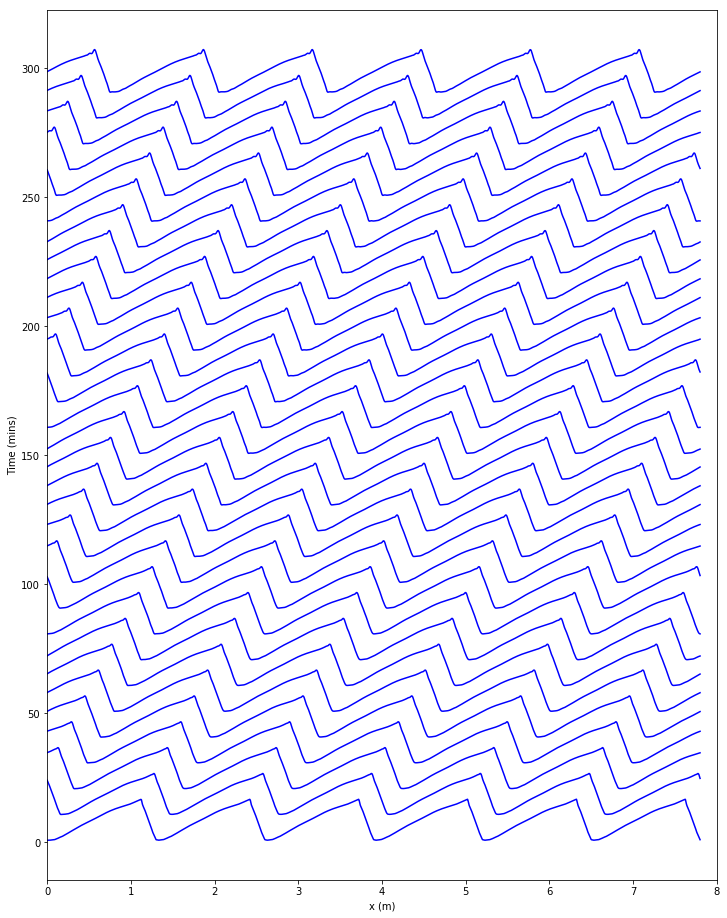

In [37]:
run_name = 'Section_5.3.dune_5_EulerWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

Text(0.5, 0, 'x (m)')

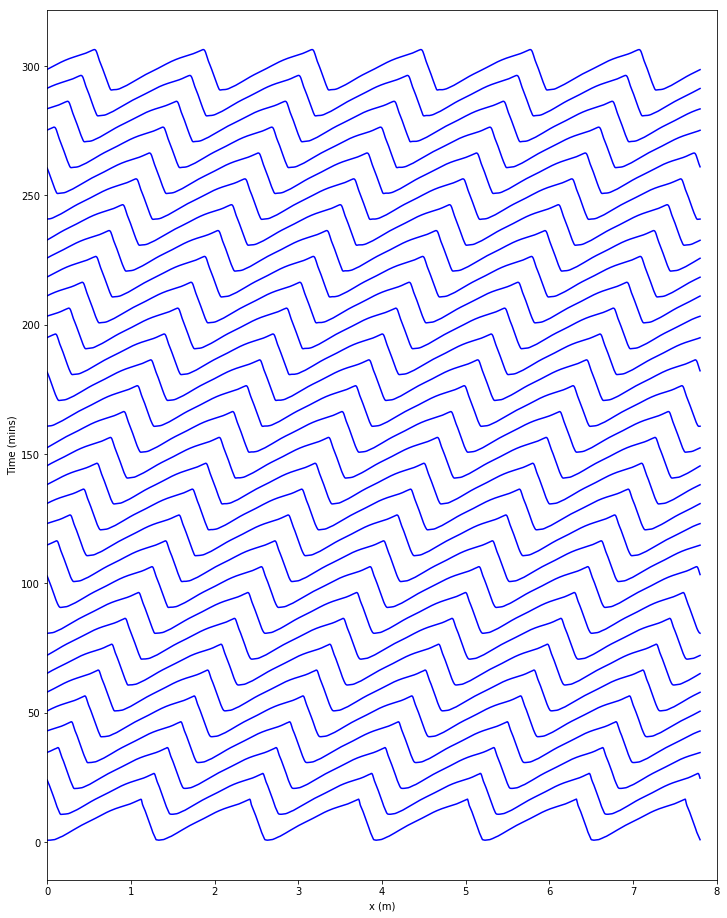

In [39]:
run_name = 'Section_5.3.dune_5_TVDWeno_q_32m_h_357mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

i=0
insert = False
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0,200*z0, color='b')

for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

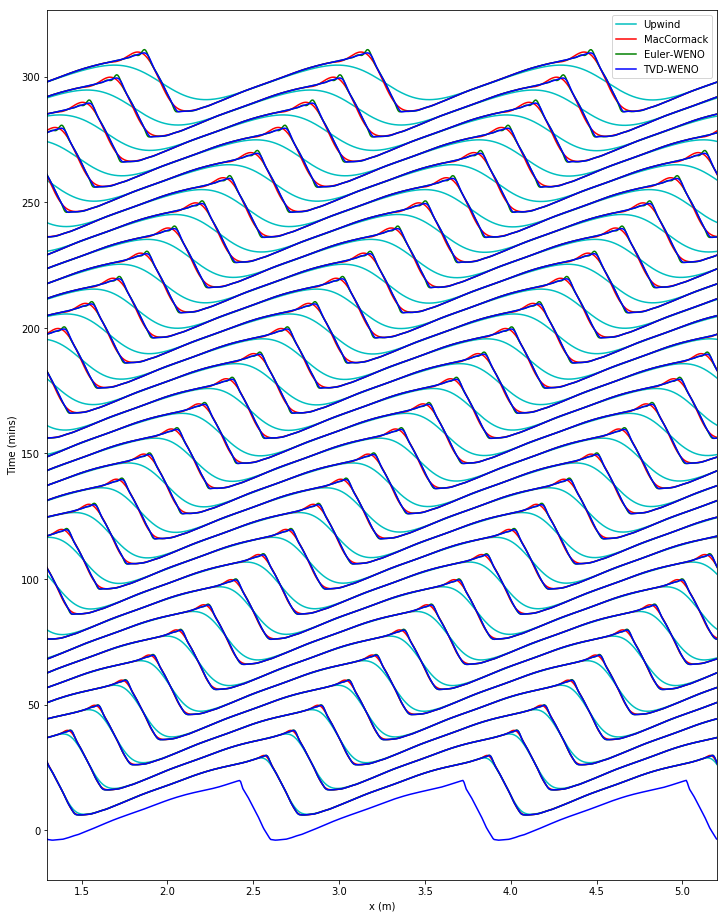

In [41]:
run_name = 'Section_5.3.dune_5_upwind_q_32m_h_357mm_D50_1.0mm_2ndTVD_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Upwind'] = verts

run_name = 'Section_5.3.dune_5_MacCormack_q_32m_h_357mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['MacCormack'] = verts

run_name = 'Section_5.3.dune_5_EulerWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Euler-WENO'] = verts

run_name = 'Section_5.3.dune_5_TVDWeno_q_32m_h_357mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['TVD-WENO'] = verts

dt = 5
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)

colors=['c','r','g','b','m']
#plt.plot(verts[0,:,0], (200*verts[0,:,1] + i*dt + 5),color='r')

plt.plot(x0, 300*z0 - 5., color='b')
j=0
nameslist=[]
arrlist =[]
firstplot = True
for verts in vertsArray.items():
    i=0
    insert = False
    name = verts[0]
    verts = verts[1]
    for t in verts[:,0,0]:
        if insert == True:
            if firstplot == True:
                plt.plot(verts[i,:,0], (300*verts[i,:,1] + i*dt),color=colors[j],label=name)
                firstplot=False
            else:
                plt.plot(verts[i,:,0], (300*verts[i,:,1] + i*dt),color=colors[j])
            insert = False
        else:
            #plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color=colors[j],label=verts[0])
            insert = True
        i+=1
    j+=1
    firstplot=True
    
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')
ax.set_xlim([1.3,4*1.3])
plt.legend()

In [182]:
import sediment_transport.sed_trans as sedtrans

run_name = 'Section_5.2_dune_5_TVDWeno_q_32m_h_357mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))

tau = [sedtrans.get_bed_shear(0.20, verts[1,i,2],0.001) for i in range((verts.shape[1]))]

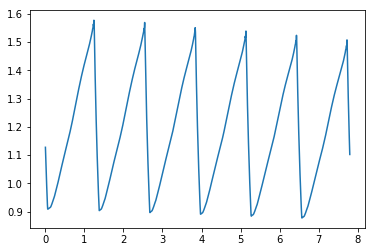

In [184]:
#self._extract_results(self._xc, self._zc, u, q, h, qbedload, timestep, dt, fileName)         
plt.plot(x0,tau)